# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [52]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://www.kickstartDS.com'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://www.kickstartDS.com
https://www.kickstartDS.com/blog/
https://www.kickstartDS.com/storybook/
https://www.kickstartDS.com/docs/
https://www.kickstartDS.com/about/
https://www.kickstartDS.com/storybook
https://www.kickstartDS.com/services/
https://www.kickstartDS.com/
https://www.kickstartDS.com/cookies/
https://www.kickstartDS.com/integrations/
https://www.kickstartDS.com/privacy/
https://www.kickstartDS.com/blog/great-components/
https://www.kickstartDS.com/legal/
https://www.kickstartDS.com/blog/setting-up-a-working-design-system-in-less-than-a-day/
https://www.kickstartDS.com/blog/unlocking-the-frontend-pt1/
https://www.kickstartDS.com/blog/quarterly-design-system-and-frontend-podcast-roundup-q1-22/
https://www.kickstartDS.com/blog/everything-meta-and-everything-matters/
https://www.kickstartDS.com/blog/kickstartds-is-open-source-now-lets-start-to-democratize-design-systems-today/
https://www.kickstartDS.com/blog/why-we-created-kickstartds/
https://www.kickstartDS.com/blog/ho

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [18]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if parsed.title.string else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

extracted: https://www.kickstartDS.com/integrations Integrations - making your interface come alive! 1419 Token, 6527
extracted: https://www.kickstartDS.com/docs/guides/create/storybook 3. Configure Storybook | kickstartDS docs 8856 Token, 32196
extracted: https://www.kickstartDS.com/docs/guides/examples/components/section Extend `Section` component | kickstartDS docs 5739 Token, 21013
extracted: https://www.kickstartDS.com/docs/guides/create/design 2. Design Application | kickstartDS docs 4565 Token, 16927
extracted: https://www.kickstartDS.com/docs/guides/components/adapt Adapt a component | kickstartDS docs 3149 Token, 14045
extracted: https://www.kickstartDS.com/docs/intro Introduction to kickstartDS | kickstartDS docs 2093 Token, 9915
extracted: https://www.kickstartDS.com/blog/everything-meta-and-everything-matters Everything Meta! And everything matters. 1013 Token, 4932
extracted: https://www.kickstartDS.com/docs/foundations/layout/sections Sections | kickstartDS docs 2000 Toke

extracted: https://www.kickstartDS.com/docs/foundations/token Token | kickstartDS docs 193 Token, 957
extracted: https://www.kickstartDS.com/docs/guides/examples/components/interstitial Create `Interstitial` component | kickstartDS docs 3398 Token, 14102
extracted: https://www.kickstartDS.com/docs/concepts Concepts | kickstartDS docs 32 Token, 126
extracted: https://www.kickstartDS.com/docs/guides/create/start 1. Start your Design System | kickstartDS docs 1514 Token, 5827
extracted: https://www.kickstartDS.com/blog/release-spotlight-semantic-token Release Spotlight: Semantic Token 1915 Token, 8975
extracted: https://www.kickstartDS.com/docs/foundations/components/component-api Component API | kickstartDS docs 125 Token, 619
extracted: https://www.kickstartDS.com/docs/integration/frameworks/nextjs Next.js | kickstartDS docs 637 Token, 2522
extracted: https://www.kickstartDS.com/blog/great-components Great components inside kickstartDS 1222 Token, 5721
extracted: https://www.kickstartDS

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [27]:
import tiktoken
import jsonlines
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

with_summaries = []
with jsonlines.open('pages_extracted.jsonl', 'r') as pages:
    for page in pages:
        with_summaries.append(page)
    
print('Creating summaries for ' + str(len(list(with_summaries))) + ' pages.')

for page in with_summaries:
    result = model(page['content']['raw'].replace('\n', ' '), num_sentences=3, min_length=60)
    page['summaries'] = dict()
    page['summaries']['sbert'] = ''.join(result)
    print()
    print(page['url'], page['title'], str(len(enc.encode(page['summaries']['sbert']))) + ' Token,', page['summaries']['sbert'])
        
with jsonlines.open('pages_extracted_summaries.jsonl', 'w') as pages:
    pages.write_all(with_summaries)

Creating summaries for 95 pages.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/integrations Integrations - making your interface come alive! 134 Token, Leverage rich integrations... ... to ease setup and everyday tasks Focus on the stuff that really matters: While having a solid Design System is the necessary start, without projects using it this is theoretical value. Complete Gatsby theme Our theme automates everything related to rendering your frontend (SEO, performance, etc), while also providing a common interface to implement your own transformers and resolvers. Connect to Design Tooling ... to help bridge the dev-design divide How Design Tokens enable better processes: Tokens are the perfect starting ground when establishing shared processes and responsibilities between designers and developers, as they encode the most atomic design decisions of your Design System.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/create/storybook 3. Configure Storybook | kickstartDS docs 214 Token, Configure Storybook Overview We use Storybook for a lot of different useful features it offers. We also tell it to put those Storybook specific files into our already existing src/token directory: With that change, re-build your Design Token set: _1yarn build-tokens You'll notice it now writes two additional files for you, specifically for the Storybook integration: Annotated tokens.css Those are all of our Design Token converted to CSS custom properties (as with src/token/tokens.css), but with the correct storybook-design-token presenters already added. You can follow the progress for this on the following ticket: kickstartDS/storybook-addon-jsonschema/issues/19 Review changes Let us review our package.json again now, it's starting to grow already: HTML rendering addon We use @whitespace/storybook-addon-html to add a tab to every component Canvas sidebar, where you can copy t

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/examples/components/section Extend `Section` component | kickstartDS docs 176 Token, Follow our main guide to learn how you can "Create your Design System" in just 5 steps: Open guide Extend Section component This guided example shows how you'd add components to your Design System that use a kickstartDS base component pretty directly. Add allowed styles 1/2 We add a style property of type string... Add allowed styles 2/2 ... and make it an enum, defining its available options explicitly. When running the schema generation in our Design System again, we should now automatically end up with a corresponding type definition to be used in creation of the template in the next step: src/components/section/SectionProps.ts src/components/section/section.schema.json _176 /* eslint-disable */ _176 /** _176 * This file was automatically generated by json-schema-to-typescript. _


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/create/design 2. Design Application | kickstartDS docs 257 Token, Design Application Overview Applying your branding and corporate design to kickstartDS is itself done in roughly two steps: - Use a reduced set of Branding Tokento generate your initial Design Tokenset - Fine tune the resulting Design Tokenset to closely fit your corporate identity Apply branding Initialization We start by creating a file branding-token.json, inside a new directory src/token... for everything to do with Design Token going forward: _2mkdir -p src/token_2touch src/token/branding-token.json This file will hold all of our Branding Token. Customize foreground and link colors For this guide we'll have just change the foreground color, but this will influence how elements and text are rendered in components. kickstartDS Integration First, add the kickstartDS CLI to your project: _1yarn add kickstartds Read more about our CLI here Then add the following two additional lin

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/components/adapt Adapt a component | kickstartDS docs 128 Token, Adapt a component Overview Adapting a component means to use the component "directly". You might need a slightly different version of the component, or its props (learn more in our guide "Customize a component", or view "Customize Headline component" as an example), or you may want to add something completely new to it (learn more in our guide "Extend a component", or view "Extend Section component" as an example). Adapt Button component In this example component guide we adapt the Button component (as part of the @kickstartDS/base module) to use it for buttons in our own Design System.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/intro Introduction to kickstartDS | kickstartDS docs 157 Token, Introduction to kickstartDS kickstartDS is an Open Source Design System starter and UI toolkit for building up your very own Design System. kickstartDS aims to be the foundation for your Design System, built with reusable components and tools itself, guided by clear standards, that can be adopted and assembled together, to create your products: fast, flexible, responsive, accessible and best of all: you can plug it onto every digital touch point you own! Or you just re-use one of those we've already written for: WordPress, Netlify CMS, Contentful, MDX Next.js Helper Use our starter to have a project running in mere minutes, or use our plugins directly to configure everything the way you like... while still profiting from work already done.

https://www.kickstartDS.com/blog/everything-meta-and-everything-matters Everything Meta! And everything matters. 163 Token, #tldr: in this post Daniel 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/foundations/layout/sections Sections | kickstartDS docs 90 Token, Sections Style A section style is mainly expressed by the given background color. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam voluptua. --l-section_col--min-width: 40% Set Columns Amount If you use a custom value, make sure the columns do not exceed the avialable space in your layout (especially on narrow screens).

https://www.kickstartDS.com/glossary/typescript TypeScript 90 Token, TypeScript In addition to using ES6 as a specific flavor, on top of JavaScript as a technology, we're using TypeScript for it's additional type safety and resulting confidence when developing long lasting, well-rounded frontend solutions like a component library. One additional feature of TypeScript we're relying heavily on is the ability to generate types for publishing packages. Read more, or chat with us, to learn how this helps create consistent frontend interfaces


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/examples/components/headline Customize `Headline` component | kickstartDS docs 110 Token, Customize Headline component This guided example shows how you'd add components to your Design System that use a kickstartDS base component pretty directly. Add allowed levels 1/2 We add a level property of type string... Add allowed levels 2/2 ... and make it an enum, defining its available options explicitly. Add Headline component 1/5 As we can't use the underlying kickstartDS base component export directly, because we intend to customize its behaviour, we start with the raw component template of the original kickstartDS Headline instead.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/intro/cli kickstartDS CLI | kickstartDS docs 182 Token, kickstartDS CLI About The kickstartDS CLI helps ease everyday tasks when working with Design Systems, especially when building on and with kickstartDS. This is the one defining kickstartDS tokens compile: https://github.com/kickstartDS/kickstartDS-cli/blob/next/.tokens-compilerc.schema.json There's also a base config included for every command, which provides the defaults in case --rc-only is supplied without a local .rc file in your project, or if that .rc file is missing some values. |Command||Subcommand||Description| |Initialize your |Design Token set from Branding Token |Compile your |Design Token set into all configured Style Dictionary formats / outputs |Sync your |Design Token set to Figma (work in progress) Schema category: Commands around working with your JSON Schema.

https://www.kickstartDS.com/storybook Webpack App 0 Token, 

https://www.kickstartDS.com/docs/integration/frameworks/gat

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/intro/packages Packages | kickstartDS docs 223 Token, Packages Packages in programming are commonly used to divide up code into distinctly (re-)usable blocks of functionality. ( This includes (non-exhaustive): - Generating JSON Schemasready for consumption - Generating TypeScripttypes for auto-completion - Transpiling code to be browser-compatible - Generating CSSbundles from SCSS If you're wondering how you'd do that in your own Design System, have a look at the final step of our main guide "Create your Design System". You can find this config on: |Category||Link| npm package registry |https://www.npmjs.com/package/@kickstartds/stylelint-config| |Our |Github mono-repository |https://github.com/kickstartDS/config/tree/master/packages/stylelint| |https://github.com/kickstartDS/config/blob/master/packages/stylelint/CHANGELOG.md| kickstartDS packages The following packages are used for our own purposes.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/components/customize Customize a component | kickstartDS docs 111 Token, Customize a component Overview Customizing a component should be part of your arsenal if you already have a specific kickstartDS component in mind, but it's missing a certain feature that you require. Adaptation process as a base line If you've read our "Adapt a component" guide you probably already know this: This guide expects you to reduce the set of props offered by kickstartDS components, when used as a base component. For the full version of customizing a Headline have a look at our "Customize Headline component" guide.

https://www.kickstartDS.com/docs/foundations/token/design-token/typo Typography | kickstartDS docs 55 Token, Typography Typography is one of the main ways you surface content in products. token.css Font Size |Token||Preview| Almost before we knew it, we had left the ground. dolor sit amet Almost before we knew it, we had left the ground.

https://www.

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/intro/environment Environment | kickstartDS docs 108 Token, Environment Everything needed for getting started with kickstartDS is a Node & npm environment. So if you're opting for yarn, be careful to not call commands link npm install, or npm run any longer. You can find our repository here: github.com/kickstartDS/kickstartDS Popular configuration guides include: GitHub: Set up Git Gitlab: Installing Git Bitbucket: Install Git Git GUI If working with the terminal is not your thing, you might want to use a dedicated Git GUI (Graphical User Interface).

https://www.kickstartDS.com/docs/integration/storybook/theming Theming | kickstartDS docs 112 Token, But while this might seem like a small thing, it can really help make your Storybook feel like home. That transformer takes your Design Token set and converts it to JavaScript values that can be imported in Storybooks theme file ( .storybook/themes.js). Example Have a look at our very own kickstartDS insta

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt


https://www.kickstartDS.com/docs/foundations/token/design-token/breakpoints Breakpoints | kickstartDS docs 57 Token, They are used to generate scales of font sizes and spacing for different screen sizes. Only one CSS custom property is created, which is read via JavaScript and used to inform components about a breakpoint change. So if you write custom styles, you have to write the media query declaration manually.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/unlocking-the-frontend-pt1 Unlocking the frontend – a call for standardizing component APIs pt.1 140 Token, tldr We’re still wasting massive amounts of valuable development cycles in the frontend world by working in silos, or by to at least some extent reinventing the wheel for every project. The main website could be built with Sanity, or other structured content-oriented solutions, as the headless CMS to really leverage connected, long-lasting content where it matters. Often even by oneself, just two projects before the current one… Why just creating a Design System is not the answer, either For product teams tasked with starting a Design System today, this also way too often feels like just another added thing on top, that’s expected to be delivered, en passant.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/release-spotlight-documentation-starter Release Spotlight: Documentation & Starter 98 Token, tldr We’ve added extensive documentation around the creation of Design Systems with kickstartDS. Foundations Our “Foundations” section describes the basic aspects of all main areas you can find in a Design System, especially when combined with the choices made in kickstartDS to be built upon. If you don’t feel like following a lengthy guide, and prefer to get going with some code immediately, it is the most efficient way of starting your Design System.

https://www.kickstartDS.com/docs/foundations/components/anatomy Anatomy | kickstartDS docs 198 Token, Anatomy Component driven development We strongly follow component driven development: https://www.componentdriven.org/ Overview of layers Different layers: - Branding Token - Design Token - Component Token - (S)CSS - JavaScript - HTML / Markup - React & TypeScript - JSON Schema Branding Token Branding Token are 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt


https://www.kickstartDS.com/docs/guides/examples/recipes Recipes | kickstartDS docs 87 Token, Recipes The recipes in a design system are like real life examples to showcase common patterns and best practice usage. Or as BRad Frost explain in his blog Recipe components are specific compositions of design system components (for the most part) that are to be consistently used across a product, but aren’t agnostic enough to live in the design system. Source: bradfrost.com We'll start adding recipe examples here!

https://www.kickstartDS.com/docs/integration/frameworks Frameworks | kickstartDS docs 53 Token, Frameworks Integration with common React frameworks can really speed up adoption, and make the difference between a successful Design System... and one that fails! Integration with common React frameworks can really speed up adoption, and make the difference between a successful Design System... and one that fails!

https://www.kickstartDS.com/docs/guides/examples Examples | kickstartD

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/create Create your Design System | kickstartDS docs 152 Token, Create your Design System Overview In this guide we'll get your first Design System, based on kickstartDS of course, off the ground in just 5 rather simple steps! The main steps involved go as follows: - Start your Design System - Design Application - Configure Storybook - Add Components - Publish your Design System The resulting Design System will obviously not be finished by the end of this guide, but you'll have everything set up to start on the real work. We'll add links along the way when it makes sense, calling out concepts at play, or processes to use, to find and refine your own personalized worfklow with kickstartDS, and ultimately your own Design System (stuff like choosing an initial component set for your Design System).

https://www.kickstartDS.com/docs/integration Integration | kickstartDS docs 59 Token, Integration There's one thing every Design System shares: it only 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/components Components | kickstartDS docs 130 Token, Components Overview There are a lot of different basic ways of building a component with kickstartDS. Accompanying each general guide is a corresponding example component guide, illustrating the process in detail for a demo component: Adapt a component: Adapt Buttoncomponent Customize a component: Customize Headlinecomponent Create a component: Create TeaserCardcomponent Extend a component: Extend Sectioncomponent Four main processes See below for a small description about the different proccesses. This means while also following everything established by "Adapt a component", we potentially add new, custom properties to our component API that were not part of the original kickstartDS base component.

https://www.kickstartDS.com/docs/foundations/components/template Template | kickstartDS docs 19 Token, ComponentsTemplateTemplate This foundations page will follow soon, please have a look back her

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/examples/components/button Adapt `Button` component | kickstartDS docs 106 Token, Adapt Button component This guided example shows how you'd often add components to your Design System that use a kickstartDS base component pretty directly. This will be a purely functional React component, mapping our component structure (as defined in the JSON Schema) to the original component we're basing our work off of; the kickstartDS Storytelling component. Add Button component 3/5 We then connect the props as defined in our component API that are directly taken from the underlying kickstartDS base component by just passing them through.

https://www.kickstartDS.com/docs/foundations/token/component-token Component Token | kickstartDS docs 59 Token, Component Token Component Token are a representation of values associated with a specific component. Whenever possible, we recommend to keep pointing these to the foundational token, rather than change into hard v

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/kickstartds-is-open-source-now-lets-start-to-democratize-design-systems-today kickstartDS is Open Source now. Let’s start to democratize Design Systems today 135 Token, Finally, the wait is over … today we are very proud to announce the Open Source release of kickstartDS. The main steps will go as follows: - Start your Design System - Design Application - Configure Storybook - Add Components - Publish your Design System Although the resulting Design System will obviously not be finished by finishing these steps, you’ll have everything set up to start on the real work. One more reason why we think: relying on kickstartDS when building your Design System is of huge value for you and the Open Source community, who can start building more adapters and implementations on top of kickstartDS to simplify the process of applying Design Systems.

https://www.kickstartDS.com/docs/foundations/components/react React | kickstartDS docs 0 Token, 


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/privacy Privacy policy 216 Token, Privacy policy Data Protection Declaration 1) Information on the Collection of Personal Data and Contact Details of the Controller 1.1 We are pleased that you are visiting our website and thank you for your interest. When you visit our website, we collect the following data that is technically necessary for us to display the website to you: - Our visited website - Date and time at the moment of access - Amount of data sent in bytes - Source/reference from which you came to the page - Browser used - Operating system used - IP address used (if applicable: in anonymized form) Data processing is carried out in accordance with Art. 9.2 RIGHT TO OBJECT IF, WITHIN THE FRAMEWORK OF A CONSIDERATION OF INTERESTS, WE PROCESS YOUR PERSONAL DATA ON THE BASIS OF OUR PREDOMINANT LEGITIMATE INTEREST, YOU HAVE THE RIGHT AT ANY TIME TO OBJECT TO THIS PROCESSING WITH EFFECT FOR THE FUTURE ON THE GROUNDS THAT ARISE FROM YOUR PARTICULAR SITUATI

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/release-spotlight-container-queries Release Spotlight: Container Queries 117 Token, tldr: Container Queries are another new feature coming with the Open Source release of kickstartDS. With Container Queries we now showcase the use and implementation of another future-proofing functionality with this, to get the perfect fit for your components, regardless of the layout they are placed into. Let me quote Brad Frost’s view on Layout & Grid in Design Systems before you hit our docs to check it out on your own - Design system developers create fully-fluid components and use container query syntaxto manage each component’s breakpoints. -

https://www.kickstartDS.com/docs/guides/migrations Migrations | kickstartDS docs 65 Token, Migrations There's currently only a single migration available. Have a look at it here for upgrade unstruction for kickstartDS 2.0.0: Upgrade 2.0.0 guide Integration with common React frameworks can really speed up adoption, and make 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/how-our-initiative-workshop-series-helps-customers-to-decide-for-or-against-a-design-system How our initiative workshop series helps customers to decide for or against building a design system 117 Token, tldr: this post explains and presents the Design System Initiative. Getting the design system initiative started During the initiative we usually run around seven to nine workshops including stakeholder mapping, exploring your current inventory as the baseline to synthesize to what should be real core components, in parallel we will sound out a strategy for the technical implementation and ultimately, we will identify a product serving as the potential pilot project. So let me sum up: The Design System Initiative helps you and your team to evaluate the key stakeholders and the necessary inventory, while ultimately, jointly, identifying a design system pilot.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/examples/components/teaser-card Create `TeaserCard` component | kickstartDS docs 178 Token, Create TeaserCard component This guided example show how to find a fitting, existing kickstartDS base component for one of your use cases, to repurpose it. 9 Start with an existing TeaserBox component variant We'll start by copying the JSX code for the Linked With Button variant of our TeaserBox component, from here: https://www.kickstartds.com/storybook/?path=/docs/base-teaser-box--linked-with-button Remove all of the unneeded stuff There are a bunch of properties that are completely optional in the copied JSX, or ones which just state the default value of that property anyway. This will be a purely functional React component, mapping our component structure (as defined in the JSON Schema) to the original component we're basing our work off of; the kickstartDS Storytelling component.

https://www.kickstartDS.com/docs/intro/upgrading Upgrading | kickstart

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt


https://www.kickstartDS.com/docs/guides/use-our-starter kickstartDS Design System Starter | kickstartDS docs 199 Token, kickstartDS Design System Starter About The kickstartDS Design System Starter is your most efficient way of kickstarting a Design System. Explore that file for details on the formats configured in this starter (the path the format output is written to can be influenced by setting buildPath): |Platform||Description| css |Creates a |Design Token converted to CSS Custom Properties, using the naming structure expected by Component Token in html HTML icon sprite (learn more), that is needed when integrating raw HTML (e.g. into PHP, ASP.NET, or similar). Components As described in the very intro to this README, all the included components should be immediately useful in pretty much every Design System, but they're also specifically used to showcase features and best practices at play in kickstartDS, and to make it easier for you to just add stuff to an already working, wel

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt


https://www.kickstartDS.com/docs/foundations/token Token | kickstartDS docs 77 Token, Based on the values they store, they are usually used across multiple tools and platforms to ensure consistence and matching brand identity. The single source of truth to name and store a design decision, distributed so teams can use it across design tools and coding languages. -W3C Design Token Community Group Inherit Token Level kickstartDS differentiates between Branding, Design and Component Token.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/examples/components/interstitial Create `Interstitial` component | kickstartDS docs 134 Token, Create Interstitial component This guided example show how to find a fitting, existing kickstartDS base component for one of your use cases, to repurpose it. Overview More concretely: what we're building up to in this example... and for the sake of imagination, assume this was what your designer cooked up: This will be done in three simple steps: - Component Definition, - Component Mapping, and - Component Creation For more details about those steps, have a look at the guide about different component processes and their shared structure. While directly helping us get a better grasp on our new component, these will also be used to write our JSON Schema later!

https://www.kickstartDS.com/docs/concepts Concepts | kickstartDS docs 32 Token, ConceptsConcepts We'll add content to this section soon, in the meantime: let us know what you'd like to read and le

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/create/start 1. Start your Design System | kickstartDS docs 230 Token, Start your Design System Overview Setting up your own Design System can be done in one of two ways: - By creating a new project for your Design System to live in, or - by adding everything to an existing project Create new project Start in a fresh directory inside your terminal. First, let's create a Git repository: _5$ mkdir -p ~/projects/my-design-system_5$ cd ~/projects/my-design-system_5$ git init_5_5> Initialized empty Git repository in ~/projects/my-design-system/.git/ Working with the terminal If any of the commands related to git or npm / node fail for you, or you need help working with the terminal, have a look at our Getting Started page about Environment configuration. We'll pretend to start fresh: Add React If your project was not using React before, you should add a compatible version ( kickstartDS currently uses React 17) of it now: _1yarn add react@17 react-dom

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/release-spotlight-semantic-token Release Spotlight: Semantic Token 111 Token, In almost every channel from the Design System space, you can feel a crispy white noise around the broad topic of Design Token. You choose your semantic token from a set of base values and scales, think of those as the painters palette, making sure there’s a lot of re-use (aliasing) in your Design Token. Unlike hassling around with configurations to be adjusted, or concepts not quite fitting your intention, this will be opinionated and tailor-made to the way we’ve approached token in kickstartDS.

https://www.kickstartDS.com/docs/foundations/components/component-api Component API | kickstartDS docs 103 Token, Component API Our Component API simplifies processes within the development tool chain by being low-code and increasing the frontend developer experience (DX) and making Design System adoption anti challenging. With „JSON schema“ we lower barriers to a huge number of oth

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/great-components Great components inside kickstartDS 99 Token, #tldr: in this post I’ll try to provide some background info on the power of kickstartDS components. Especially how well-curated component options, connected with carefully chosen design and component tokens, give you a nice expressive workbench… all while providing safety, by keeping you inside set (design system) guard rails in regards to branding and consistency. This is just one more example of what differentiates our components, making them a great experience for all parties involved.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com kickstartDS – Open Source starter kit and low-code framework for Design Systems 144 Token, kickstartDS is the Open Source starter kit for Design Systems A low-code framework and comprehensive component library enabling digital teams to create consistent and brand compliant web frontends super efficiently. Alternatively, use our ready-to-use React components directly in your codebase! Make it your own Learn how kickstartDS helps in building your Design System Great Open Source components Components serving as the basic building blocks of your Design Systen kickstartDS is the foundation for your Design System, built with reusable components and tools, guided by clear standards, that can be assembled together to create your products: fast, flexible, responsive, accessible and the best of all: 👉 you can plug it onto every digital touch point you own.

https://www.kickstartDS.com/cookies https://www.kickstartDS.com/cookies 0 Token, 

https://www.kickstartDS.com/

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/components/create Create a component | kickstartDS docs 105 Token, Create a component Overview Creating a component differs from "just" adapting a component in that it starts out without a specific kickstartDS component already in mind. We also have an additional example in "Create Interstitial component", but to actually implement that you need access to our kickstartDS content module. Create TeaserCard component In this example component guide we create the TeaserCard component, mapped to the TeaserBox component (part of the @kickstartDS/base module), to tease content in our Design System.

https://www.kickstartDS.com/docs/foundations/layout Layout | kickstartDS docs 47 Token, Layout Layouting helps give context to your components, that were developed in isolation otherwise. They help present and structure your content, supporting consistency across your applications. Layouting helps give context to your components, that were developed in isol

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/why-we-created-kickstartds Why we are creating kickstartDS 97 Token, #tldr: We want to support you to create one library of components, patterns and tokens to be used in any frontend you need to give your digital touch points a consistent interface. Even shorter: we want to kickstart your design system implementation. With the ambitious idea of transforming it into a product-led company we decided to join forces and strive for the most modern solution to help SMEs and frontend development teams to build up their design systems putting frontend first!

https://www.kickstartDS.com/docs/foundations/layout/bedrock Bedrock | kickstartDS docs 108 Token, Bedrock We use Bedrock as our library of choice when it comes to layouting: A collection of utility components that are designed to be used as building blocks for your web application's layout. This makes it necessary to add dedicated layout functionality to your Design System, to help users actually create p

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/design-system-initiative Design System Initiative | kickstartDS docs 103 Token, Design System Initiative A Design System Initiative is the process an organization undertakes when considering to initialize a Design System. Examplary Design System Initiative Process During the initiative we usually run around seven to nine workshops including stakeholder mapping, exploring your current inventory as the baseline to synthesize to what should be real core components, in parallel we will sound out a strategy for the technical implementation and ultimately, we will identify a product serving as the potential pilot project. Plus, you will better understand the existing design and development processes.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/components/extend Extend a component | kickstartDS docs 106 Token, Extend a component Overview Extending a component takes a kickstartDS component and expands upon its abilities. Adaptation process as a base line If you've read our "Adapt a component" guide you probably already know this: This guide expects you to reduce the set of props offered by kickstartDS components, when used as a base component. Extend Section component In this example component guide we extend the Section component (as part of the @kickstartDS/base module) to use it for sections in our own Design System.

https://www.kickstartDS.com/docs/guides/examples/recipes/article-teaser Article Teaser recipe | kickstartDS docs 12 Token, Article Teaser recipe We're currently finishing up this recipe!


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/blog/setting-up-a-working-design-system-in-less-than-a-day Setting up a working Design System in less than a day 172 Token, tldr: In this post I’d like to demonstrate how easy it can be to kick off your own Design System, by just applying some design tokens, and adding a sprinkle of customization, using kickstartDS. Have a look at the screenshot below, to get a feel for how this looks: Token application With all those macro design decisions out of the way, I could now move on with customizing the individual token values, which got generated for me from the theming input I defined before. At that point the pages were starting to look almost identical… I had to re-check the URL to make sure what page I was on 😉 Customization If you want to step outside the foundational layer of design tokens automatically available to you, and get really creative with your styling, you can always just as easily customize the components more directly.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



https://www.kickstartDS.com/docs/guides/create/components 4. Add Components | kickstartDS docs 118 Token, Add Components Now we'll get to the meat of it... adding our first set of components based on kickstartDS. Component implementation We roughly see four different ways of adding a component to your Design System, in the context of kickstartDS. Those are most definitely not exhausting, but they serve as a good introduction: Adapta component ( Button) Createa component ( Headline) Customizea component ( TeaserCard) Extenda component ( Section) We'll follow one guide for each of those general workflows, resulting in the four planned components being added to our Design System.

https://www.kickstartDS.com/docs/integration/storybook/token Design & Component Token | kickstartDS docs 100 Token, Design & Component Token Design Token Integration To display your Design Token set in Storybook we use and recommend the storybook-design-token addon. We also provide ready-to-use docs pages for S

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [30]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

with_sections = []
with jsonlines.open('pages_extracted_summaries.jsonl') as pages:
    for page in pages:
        outputs = []
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
        df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
        df = df[df.tokens>40]
        df = df.drop_duplicates(['title','heading'])
        df = df.reset_index().drop('index',axis=1) # reset index
        df.head()

        result = df.to_json(orient="records")
        parsed = json.loads(result)
        page['sections'] = parsed
        
        with_sections.append(page)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(with_sections)
    
print('Extracted sections for ' + str(len(with_sections)) + ' pages.')

Extracted sections for 95 pages.


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-05 22:54:30,397 - top2vec - INFO - Pre-processing documents for training
2023-03-05 22:54:30,509 - top2vec - INFO - Creating joint document/word embedding


586 documents added for topic generation.


2023-03-05 22:54:56,129 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-05 22:54:58,167 - top2vec - INFO - Finding dense areas of documents
2023-03-05 22:54:58,179 - top2vec - INFO - Finding topics



7 topics discovered.

Top topic returned for keyword search "component":

Top 10 words by similarity to keyword "component":
base 0.5780046839163224
components 0.5308766141531922
customize 0.5075987882382023
ll 0.4993233650747265
create 0.4769122104894218
headline 0.4763100606636875
adapt 0.4721412020881859
api 0.4663448933745207
properties 0.45113042975308937
template 0.44519046168120413

Top 10 sections / topic
Topic 0
Document: 33, Score: 0.478508859872818
-----------
Extend `Section` component | kickstartDS docs Summary Follow our main guide to learn how you can "Create your Design System" in just 5 steps: Open guide
Extend Section component
This guided example shows how you'd add components to your Design System that use a kickstartDS base component pretty directly. But unlike just adapting a component, extending a component also involves adding something to it, or changing the way certain things work under the hood, by composing multiple kickstartDS base components (whereas cust

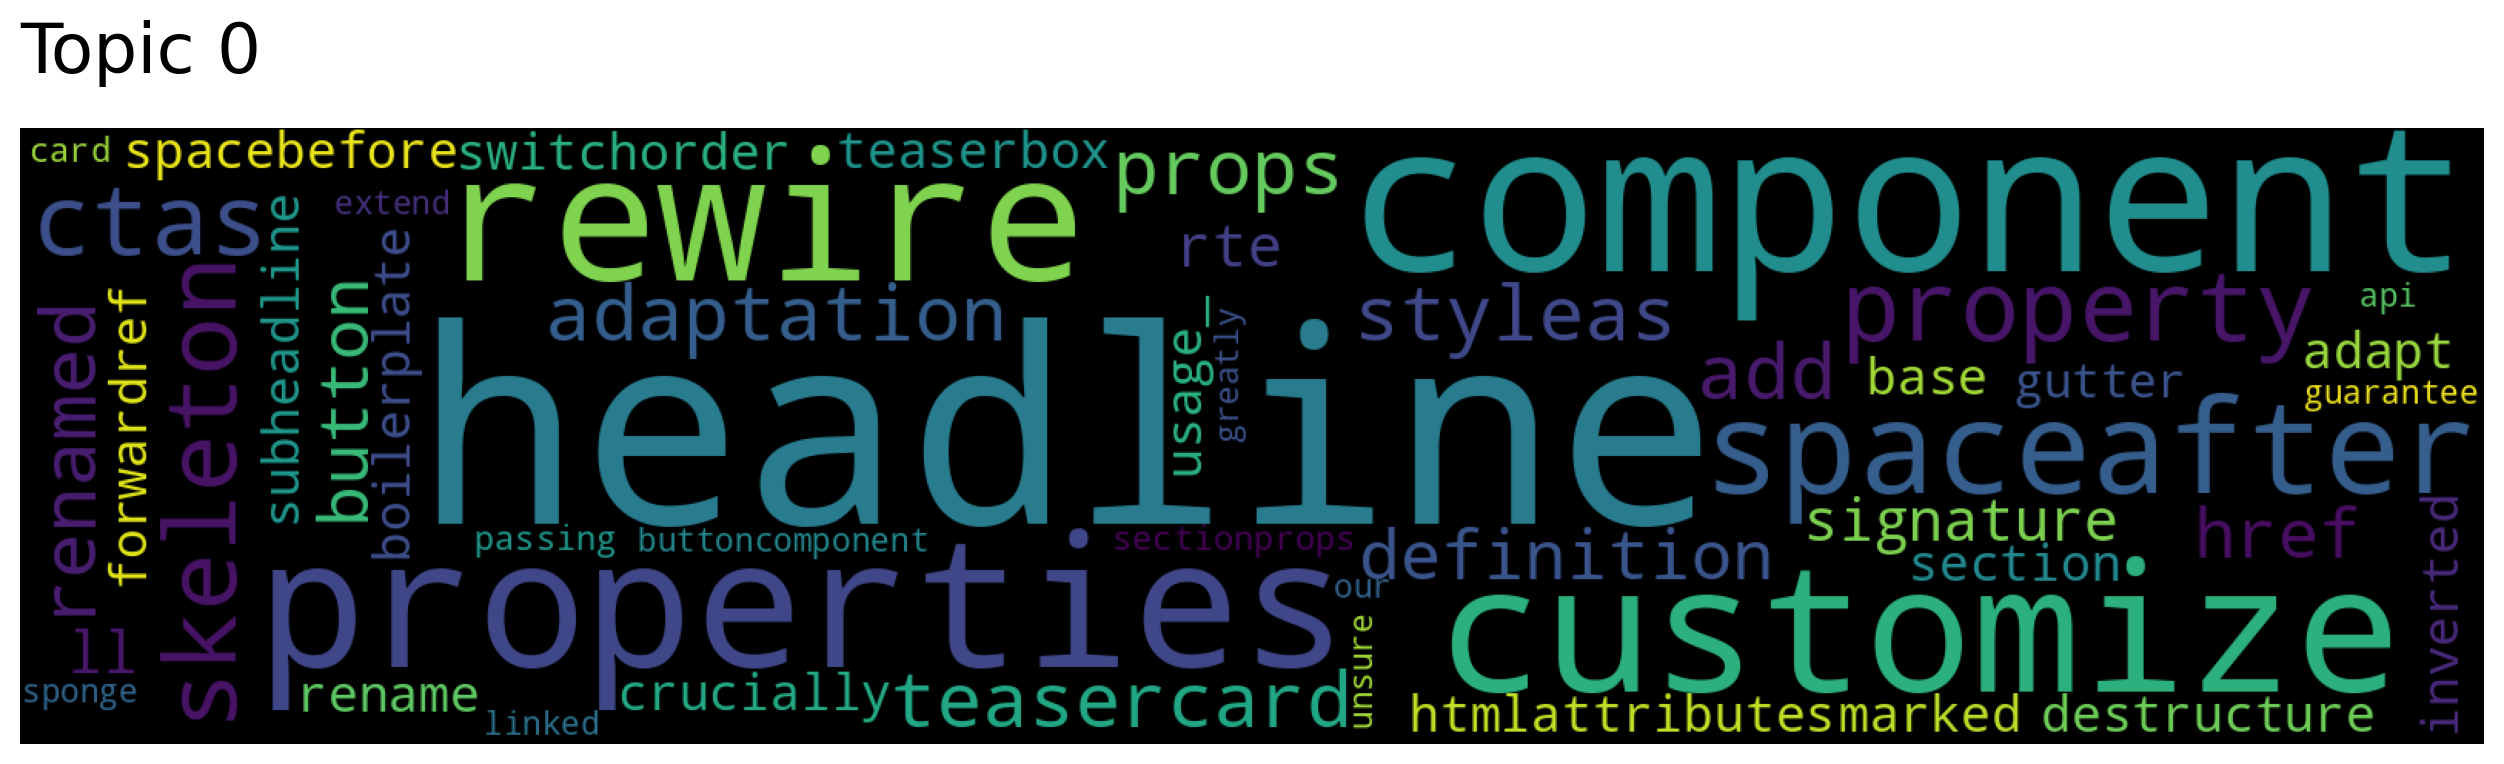

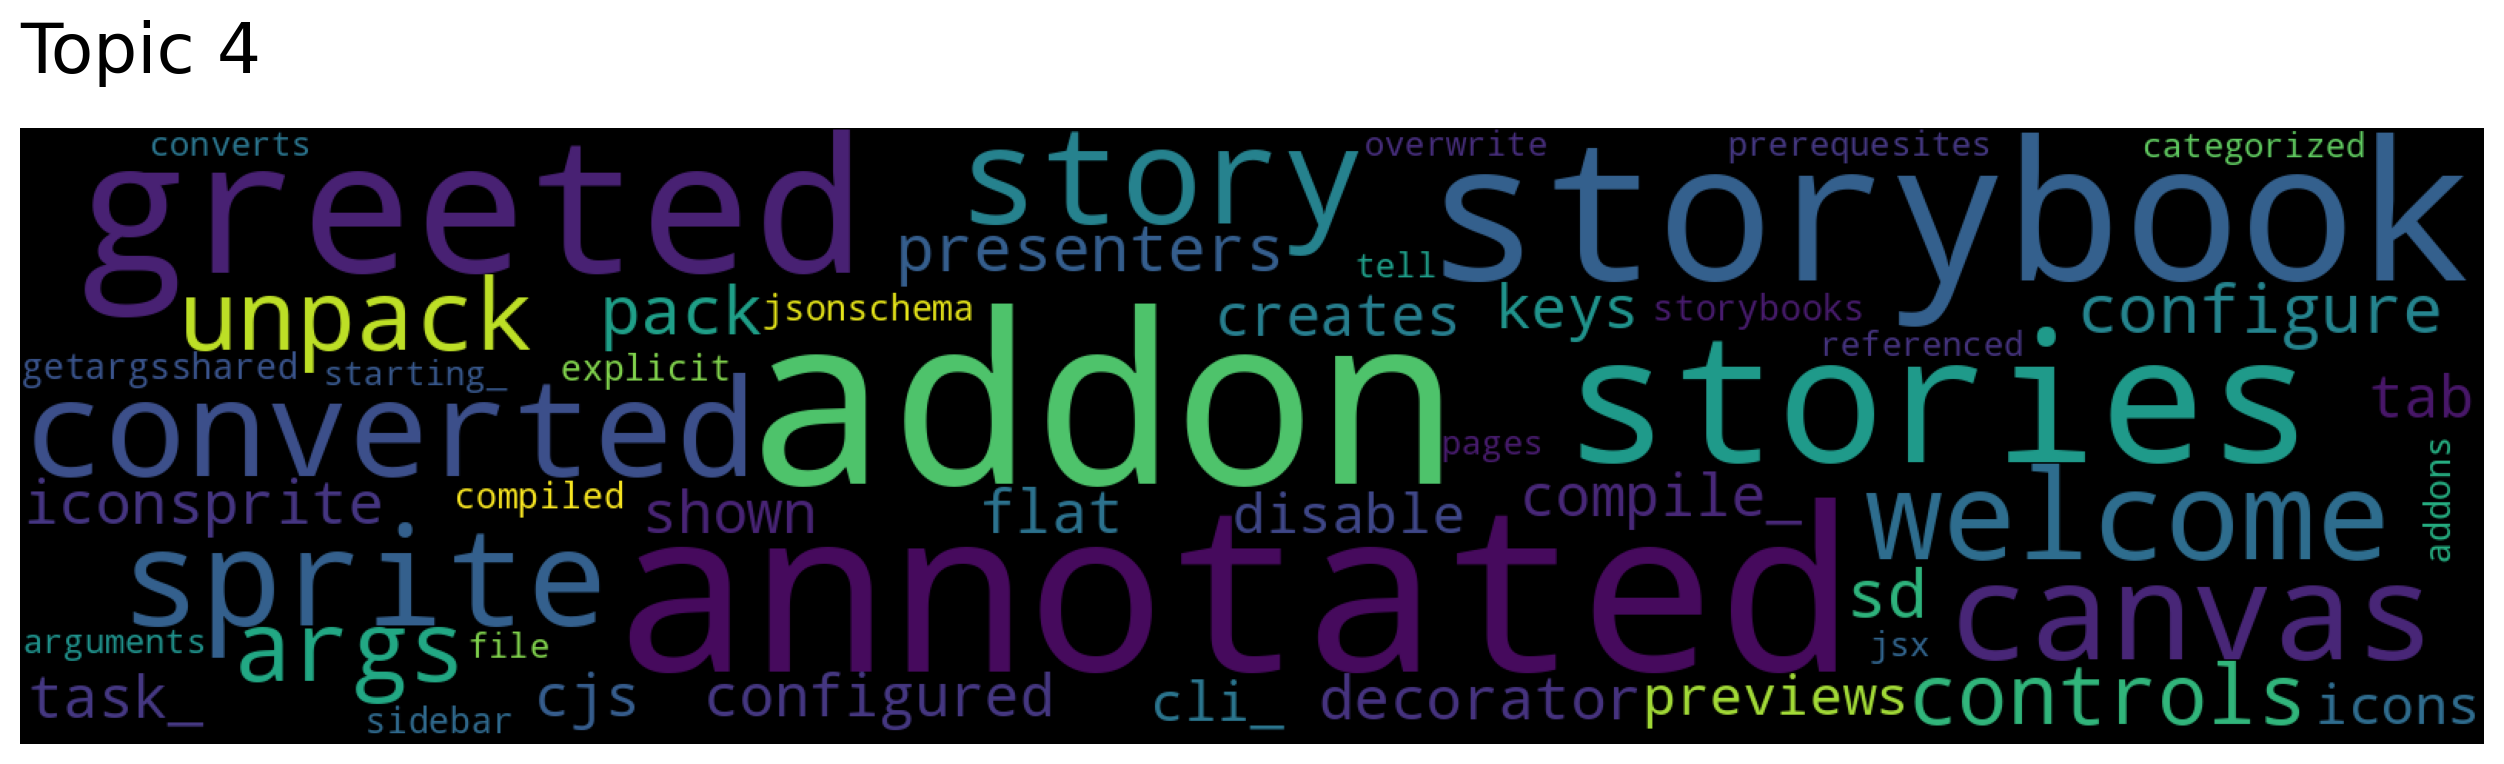

In [36]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        for section in page['sections']:
            documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top topic returned for keyword search "component":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["component"], num_topics=2)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "component":')
words, word_scores = model.similar_words(keywords=["component"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections / topic')
for topic in topic_nums:
    print('Topic ' + str(topic))
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic, num_docs=10)
    for doc, score, doc_id in zip(documents, document_scores, document_ids):
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()
  
print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["component", "create"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [37]:
import json
import gzip
import os
import torch
from sentence_transformers import SentenceTransformer, CrossEncoder, util

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")

#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def getSectionContent(section):
    return section['title'] + ': ' + section['content']

passages = []
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        #Add all paragraphs
        passages.extend(map(getSectionContent, page['sections']))

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

Passages: 586


Batches: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.97it/s]


In [38]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

import string
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
from tqdm.autonotebook import tqdm

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

100%|████████████████████████████████████████████████████████████████████████████| 586/586 [00:00<00:00, 19321.30it/s]


In [39]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))

In [40]:
search("What are the benefits of kickstartDS?")

Input question: What are the benefits of kickstartDS?
Top-5 lexical search (BM25) hits
	8.756	3. Configure Storybook | kickstartDS docs: We define a title and category for our Welcome page by importing and using Meta from @storybook/addon-docs, a component provided to us by Storybook. This would also be a first example on the benefits of using .mdx for documentation.
	7.696	Introduction to kickstartDS | kickstartDS docs: kickstartDS focuses on the consistent frontend UX and UI interaction of components — colors, layout, interactions, animations. It's easy to adapt, and integrates with every frontend-approach that works with regular HTML. Additionally, under the hood, React is used as the templating layer of choice, but integration into your templating layer, or backend, of choice is in no way limited by this, as everything is written to be usable without a React runtime! Only development of new components involves, and benefits by, the use of React!
	6.660	kickstartDS is Open Source no